# Lag Time Analysis: Prepare station data
This notebook contains all of the work needed to prepare a dataset of stream gauge stations. It contains:
- a list of all of the nearby stations in the West Branch of the Susquehanna
- adds data on the downstream distance to each station
- adds data on the station's datum height, wateshed area, & station name
- calculates a stage correction based on the minimum stage during the 2012-2016 water years
- calculates a stage correction based on the rating curve
- saves the stations used in the analysis to station.parquet

In [1]:
import hydrofunctions as hf
print("Hydrofunctions version: ", hf.__version__)

import pandas as pd
pd.set_option('display.max_columns', None) # This changes the default to show all 35 columns of our data when we display it.
print("Pandas version: ", pd.__version__)

import numpy as np

import matplotlib.pyplot as plt
#%matplotlib notebook
# Use the following for JupyterLab instead:
%matplotlib inline
import seaborn as sns

from scipy.stats import linregress
print("Imports complete.")

Hydrofunctions version:  0.2.4
Pandas version:  2.2.3
Imports complete.


# List of all sites from the West Branch to the Chesapeake Bay

This is a list of sites along the West Branch and main stem of the Susquehanna.

*starred sites aren't in the GAGES-II database.  
X sites didn't return data during the big P10D request.

- X\*01579550 Darlington - Not in NHD
- *01578310 Conowingo
- X*01576980 Holtwood Dam - Not in NHD
- \*01576000 Marietta:  *Data collected every half-hour*
- \*01570500 Harrisburg:  *Data collected every half-hour*
- 01554000 Sunbury
- X*01553990 Above Dam at Sunbury
- 01553500 WB Lewisburg
- X*01553240 WB Milton
- *01553025 WB Allenwood - slightly regulated by six US flood-control dams
- 01551500 WB Williamsport
- low-head dam less than 100m US of Williamsport gauge; ~ 1m unregulated run-of-river
- *01549760 WB Jersey Shore - starts collecting real-time data in 2014
- low-head dam within 100m DS of Lock Haven gauge; ~1m unregulated run-of-river
- *01545800 WB Lock Haven - starts collecting real-time data in 2017
    - Foster Joseph Sayers Dam on Eagle Creek; Flood control
- 01545500 WB Renovo
    - Alvin R. Bush Dam on Kettle Creek; Flood control
    - George B. Stevenson Dam on a tributary to Sinnemahoning Creek; Flood control
- 01542500 WB Karthaus
- low-head dam at Shawville Generating Plant; could be 2m high?
- low-head dam at Clearfield; unregulated run-of-river. Could be 2m high?
- 01541303 WB Hyde - controlled by Curwensville Dam, 5 miles upstream
- very low-head dam within 30m of Curwensville gauge
- 01541200 WB Curwensville - controlled by Curwensville Dam
- X*01541180  Curwensville Lake - Only gathers parameter code 00062, reservoir height in feet
- 01541000 WB Bower


In [2]:
# The "Susquehanna_Merge_Table.txt" file was created in ArcGIS from NHD; it is a table of the
# river segments from the NHD merged into reaches that stretch between each stream gauge on 
# the river. Length is given in meters. Stream gauges are listed by their USGS ID#.
reaches = pd.read_csv('Susquehanna_Merge_Table.txt', dtype={'US_Gauge':str, 'DS_Gauge':str})
reaches.sort_values(by=['US_Gauge'], ascending=False, inplace=True)
reaches

,OBJECTID,Resolution,GNIS_ID,GNIS_Name,Enabled,Shape_Length,US_Gauge,DS_Gauge
1,13,2,591690,Susquehanna River,1,15883.059023,01578310,1
2,17,2,591690,Susquehanna River,1,58285.801779,01576000,01578310
4,21,2,591690,Susquehanna River,1,43932.205520,01570500,01576000
0,3,2,591690,Susquehanna River,1,85515.181896,01554000,01570500
5,113,2,591690,Susquehanna River,1,2227.030054,01553990,01554000
3,20,2,591690,Susquehanna River,1,16102.814311,01553500,01553990
17,662,2,1190936,West Branch Susquehanna River,1,4984.378895,01553240,01553500
6,650,2,1190936,West Branch Susquehanna River,1,12150.742787,01553025,01553240
9,653,2,1190936,West Branch Susquehanna River,1,34211.007080,01551500,01553025
14,658,2,1190936,West Branch Susquehanna River,1,26086.792646,01549760,01551500


In [3]:
# The 'positionNHD' field is the distance from the gauge to the Chesapeake Bay in meters.
reaches.loc[:,'positionNHD'] = reaches.loc[:,'Shape_Length'].cumsum()
reaches

,OBJECTID,Resolution,GNIS_ID,GNIS_Name,Enabled,Shape_Length,US_Gauge,DS_Gauge,positionNHD
1,13,2,591690,Susquehanna River,1,15883.059023,01578310,1,15883.059023
2,17,2,591690,Susquehanna River,1,58285.801779,01576000,01578310,74168.860803
4,21,2,591690,Susquehanna River,1,43932.205520,01570500,01576000,118101.066322
0,3,2,591690,Susquehanna River,1,85515.181896,01554000,01570500,203616.248218
5,113,2,591690,Susquehanna River,1,2227.030054,01553990,01554000,205843.278272
3,20,2,591690,Susquehanna River,1,16102.814311,01553500,01553990,221946.092583
17,662,2,1190936,West Branch Susquehanna River,1,4984.378895,01553240,01553500,226930.471478
6,650,2,1190936,West Branch Susquehanna River,1,12150.742787,01553025,01553240,239081.214266
9,653,2,1190936,West Branch Susquehanna River,1,34211.007080,01551500,01553025,273292.221345
14,658,2,1190936,West Branch Susquehanna River,1,26086.792646,01549760,01551500,299379.013991


In [4]:
# List of Sites that contain 15-minute data.
sites = [
'01578310',
'01554000',
'01553500',
'01553025',
'01551500',
'01549760',
'01545800',
'01545500',
'01542500',
'01541303',
'01541200',
'01541180',
'01541000']
# List of sites that collect data every half-hour.
halfhr = ['01576000', '01570500']
all_sites = sites + halfhr
len(sites), len(halfhr), len(all_sites)

(13, 2, 15)

# Create a table of station information.
- site_index is the USGS station ID#
- name is a shortened version of the station name
- position1_m is the distance DS from the Bower station in meters, recorded by me
- position_m is the distance DS from the Bower station in meters, recorded by Lyw.
- position_nhd_m is the distance US from the Chesapeake Bay in meters, as calculated from the NHD HR.
- gauge_datum is feet above NGVD 1929; taken from site page.
- gauge_datum_m is meters above NGVD 1929; converted from gauge_datum * 0.3048
- basin_area_km2 is watershed area converted to km^2 from the site page.
- medianQ is the median discharge, in cfs.

In [5]:
site_index = ['01541000', '01541180', '01541200', '01541303', '01542500', '01545500', '01545800', '01549760', '01551500', '01553025', '01553240', '01553500']
site_data = {'name': ['Bower', 'Lake', 'Curwensville', 'Hyde', 'Karthaus', 'Renovo', 'LockHaven', 'JerseyShore', 'Williamsport', 'Allenwood',
                     'Milton', 'Lewisburg'],
            #'position1_m': [0, None, 27950, 41210, 112190, None, None, None, None, None, None, None],
            #'position_m':[0, None, 35084, 52625, 147416, 221284, 279864, 310764, 345203, 390265, 405071, 412957],
             'position_nhd_m':[537015, 508459, 507322, 494288, 422588, 367064, 321892, 299379, 273292, 239081, 226930, 221946],
             'gauge_datum':[1207.14, 0, 1124.66, 1093.90, 830.59, 634.19, 534.519, 513.19, 494.98, None, None, None],
             'basin_area_km2':[816, 945, 951, 1228, 3787, 7705, 8664, 13533, 14716, None, None, None]
            }
tempstations = pd.DataFrame(data=site_data, index=site_index)
tempstations['gauge_datum_m'] = tempstations['gauge_datum'] * 0.3048

# Calculate median discharge as the median of all values in the dataset created in LTA_0_Data-Download. units = cubic meters / second
Q = pd.read_parquet('WBdata-discharge.parquet')
median = Q.median()
median.name = 'medianQ_cms'
allstations = pd.concat([tempstations, median], axis=1)

allstations

,name,position_nhd_m,gauge_datum,basin_area_km2,gauge_datum_m,medianQ_cms
01541000,Bower,537015,1207.140,816.0,367.936272,NaN
01541180,Lake,508459,0.000,945.0,0.000000,NaN
01541200,Curwensville,507322,1124.660,951.0,342.796368,9.967514
01541303,Hyde,494288,1093.900,1228.0,333.420720,14.186717
01542500,Karthaus,422588,830.590,3787.0,253.163832,40.209856
01545500,Renovo,367064,634.190,7705.0,193.301112,84.667232
01545800,LockHaven,321892,534.519,8664.0,162.921391,NaN
01549760,JerseyShore,299379,513.190,13533.0,156.420312,NaN
01551500,Williamsport,273292,494.980,14716.0,150.869904,161.972096
01553025,Allenwood,239081,NaN,NaN,NaN,NaN


# Create a subset for analysis.

- Only keep stations upstream from Williamsport to avoid effect of dams DS from this site.
- Only keep stations DS of the Curwensville Dam, starting with Curwensville.
- LockHaven 01545800 doesn't have data until 2017, so drop it.
- JerseyShore 01549760 doesn't have data until 2014, so drop it.
- The Curwensville Dam is located between Bower and Curwensville; Lake is located on the reservoir and only measures lake level.
- Drop Bower. As seen in LTA_0_Data-Download.ipynb, Bower is missing 13% of data, and
- Curwensville is affected by the Curwensville Dam; it can't be matched to Bower or Lake upstream of the dam.
- Drop Lake; this site records reservoir height, which does not behave like stage and can't be matched to Curwensville either.

In [6]:
analysis_sites = ['01541200', '01541303', '01542500', '01545500', '01551500']
stations = allstations.loc[analysis_sites,['name', 'position_nhd_m', 'gauge_datum_m', 'basin_area_km2', 'medianQ_cms']]
stations

,name,position_nhd_m,gauge_datum_m,basin_area_km2,medianQ_cms
01541200,Curwensville,507322,342.796368,951.0,9.967514
01541303,Hyde,494288,333.420720,1228.0,14.186717
01542500,Karthaus,422588,253.163832,3787.0,40.209856
01545500,Renovo,367064,193.301112,7705.0,84.667232
01551500,Williamsport,273292,150.869904,14716.0,161.972096


In [7]:
# Set colors for each station for standarized plotting
site_color = {'01541200': '#fc8d62', 
              '01541303': '#8da0cb', 
              '01542500': '#e78ac3', 
              '01545500': '#a6d854', 
              '01551500': '#66c2a5'}
site_color = {
    '01541200': '#4a58dd', 
    '01541303': '#27d7c4', 
    '01542500': '#95fb51', 
    '01545500': '#ffa423', 
    '01551500': '#ba2208'
}
color = pd.DataFrame.from_dict(data=site_color, orient='index', columns=['color'])
stations = pd.concat([stations, color], axis=1)
stations

,name,position_nhd_m,gauge_datum_m,basin_area_km2,medianQ_cms,color
01541200,Curwensville,507322,342.796368,951.0,9.967514,#4a58dd
01541303,Hyde,494288,333.420720,1228.0,14.186717,#27d7c4
01542500,Karthaus,422588,253.163832,3787.0,40.209856,#95fb51
01545500,Renovo,367064,193.301112,7705.0,84.667232,#ffa423
01551500,Williamsport,273292,150.869904,14716.0,161.972096,#ba2208


# Stage Correction
Stage is reported by the USGS as a height above a datum. The datum is usually set so that there will never be a negative reading, even if there is some scour over the years at the station site.  For this analysis, I need to have an estimate of the water depth. In the thalwag of the stream, the depth of the water will be the height of the water surface (aka the stage) minus the height (stage) of the water surface at zero discharge. For the rest of the cross-section, the depth of the water will be less than this value. I will refer to this value as the 'depth' or 'thalwag depth' from here on out...

This page will estimate the water surface height at zero discharge by regressing stage against discharge and using the y-intercept as the zero-discharge value. The stage-discharge relationship is also known as the 'rating curve'. Because the rating curve is non-linear, I will fit a line using only the lowest stage values.

In [8]:
# The column names are the station ID#
# Stage is in meters above an arbitrary local datum. (gauge_datum & gauge_datum_m in the stations table)

stage = pd.read_parquet('WBdata-stage.parquet')
stage.head()

,01541200,01541303,01542500,01545500,01551500
datetimeUTC,,,,,
2012-10-01 04:00:00+00:00,1.094232,0.9906,0.554736,0.256032,0.411480
2012-10-01 04:15:00+00:00,1.097280,0.9906,0.554736,0.256032,0.411480
2012-10-01 04:30:00+00:00,1.094232,0.9906,0.554736,0.249936,0.414528
2012-10-01 04:45:00+00:00,1.094232,0.9906,0.551688,0.249936,0.414528
2012-10-01 05:00:00+00:00,1.094232,0.9906,0.551688,0.246888,0.414528


In [9]:
# discharge is given in meters³/second
Q = pd.read_parquet('WBdata-discharge.parquet')
Q.head()

,01541200,01541303,01542500,01545500,01551500
datetimeUTC,,,,,
2012-10-01 04:00:00+00:00,6.852666,7.249101,18.462554,37.944512,83.534560
2012-10-01 04:15:00+00:00,6.965933,7.249101,18.462554,37.944512,83.534560
2012-10-01 04:30:00+00:00,6.852666,7.249101,18.462554,37.378176,84.100896
2012-10-01 04:45:00+00:00,6.852666,7.249101,18.292653,37.378176,84.100896
2012-10-01 05:00:00+00:00,6.852666,7.249101,18.292653,37.095008,84.100896


# Calculate an estimate of stage when discharge is zero.
This analysis is based on the rating curve: stage vs. discharge.
The rating curve is non-linear. Instead of fitting a non-linear model to the entire rating curve, I will
fit a linear regression to the lowest part of each curve, below a 'cutoff' value.

In [10]:
# These cutoff values are the highest stage value that will be considered in fitting a linear model to the rating curve.
# Because the rating curve is non-linear, we are only interested in extrapolating a line from the very lowest stages.
# Trying to fit a power function, polynomial, or other non-linear model to the entire dataset won't produce a more accurate
# estimate of the stage at zero-discharge because the stage-discharge relationship at the lowest  discharges can take any form
# and is not influenced by what happens at higher discharges.

# We will only fit the linear models from these cutoff stages and lower.
#cutoff = {'01541200':3.5,'01541303':3.2,'01542500':1.8,'01545500':0.7,'01551500':0.6}
cutoff = {'01541200':1.0,'01541303':1.0,'01542500':0.5,'01545500':0.2,'01551500':0.2}
linear = {}
print('        gradient    intercept  r_value      p_value    std_err')
print('-----------------------------------------------------------------')
for site in analysis_sites:
    criteria1 = Q.loc[:,site].notnull()  # Screen out all NaNs in the discharge dataset. If Q & stage were in the same df, you could just use .dropna()
    criteria2 = stage.loc[:,site]<cutoff[site]   # The linear regression should only be fit to stage values lower than the cutoff.
    selector = criteria1 & criteria2
    
    # Stage & discharge are in meters & m³/s
    y = stage.loc[selector, site]
    X = Q.loc[selector, site]
    rootX = np.sqrt(X)  # Fenton & Keller 2001 recommend fitting line on stage vs √Q
    # Using √Q transformation produces better estimates of intercept: stage of zero discharge

    print(f'{site}:')
    gradient, intercept, r_value, p_value, std_err = linregress(X,y)
    print(f'on Q:   {gradient:8.4f} {intercept:11.4f} {r_value:8.4f} {p_value:10.2f} {std_err:12.4f}')
    gradient2, intercept2, r_value2, p_value2, std_err2 = linregress(rootX,y)
    print(f'on √Q:  {gradient2:8.4f} {intercept2:11.4f} {r_value2:8.4f} {p_value2:10.2f} {std_err2:12.4f}\n')
    
    output = []
    output.append(intercept) # We name this 'StageQ0', the stage when discharge = 0
    output.append(intercept2) # We name this 'StageQ0root', and is another estimate of stage when Q = 0
    output.append(X.max()) # 'maxQ'- Highest measured discharge used in constructing the linear equation
    output.append(X.min()) # 'minQ'- Lowest measured discharge used in constructing the linear equation
    output.append(gradient2 * X.max()**0.5 + intercept2) # 'maxY' is y = mx+b at X.max
    output.append(gradient2 * X.min()**0.5 + intercept2) # 'minY' is y = mx+b at X.min
    output.append(gradient2)
    output.append(y.min()) # 'StageMin'- the lowest recorded stage; it can serve as another estimate of stage ot zero/low discharge
    linear[site] = output
DF = pd.DataFrame.from_dict(data=linear, columns=['StageQ0', 'StageQ0root', 'maxQ', 'minQ', 'maxY', 'minY', 'gradient_root', 'StageMin'], orient='index')
DF

        gradient    intercept  r_value      p_value    std_err
-----------------------------------------------------------------
01541200:
on Q:     0.0476      0.7482   0.6262       0.00       0.0004
on √Q:    0.1818      0.5797   0.6478       0.00       0.0013

01541303:
on Q:     0.0288      0.7830   0.9866       0.00       0.0000
on √Q:    0.1273      0.6454   0.9898       0.00       0.0001

01542500:
on Q:     0.0180      0.1960   0.9182       0.00       0.0000
on √Q:    0.1245     -0.0163   0.9218       0.00       0.0003

01545500:
on Q:     0.0131     -0.2106   0.9864       0.00       0.0000
on √Q:    0.1191     -0.4745   0.9916       0.00       0.0001

01551500:
on Q:     0.0094     -0.2610   0.9908       0.00       0.0000
on √Q:    0.1103     -0.5813   0.9940       0.00       0.0001



,StageQ0,StageQ0root,maxQ,minQ,maxY,minY,gradient_root,StageMin
01541200,0.748196,0.579685,6.173062,1.158157,1.031434,0.775358,0.181822,0.701040
01541303,0.782976,0.645428,8.523357,2.132255,1.016945,0.831248,0.127255,0.835152
01542500,0.195998,-0.016348,18.774038,5.889894,0.522899,0.285691,0.124454,0.280416
01545500,-0.210584,-0.474518,34.263328,9.202960,0.222642,-0.113207,0.119102,-0.115824
01551500,-0.260989,-0.581263,50.970240,19.312058,0.206119,-0.096598,0.110288,-0.100584


In [11]:
final_stations = pd.concat([stations,DF.loc[:,['StageQ0root', 'StageMin']]], axis=1)
#Save file
final_stations.to_parquet('stations.parquet', compression='gzip')
final_stations

,name,position_nhd_m,gauge_datum_m,basin_area_km2,medianQ_cms,color,StageQ0root,StageMin
01541200,Curwensville,507322,342.796368,951.0,9.967514,#4a58dd,0.579685,0.701040
01541303,Hyde,494288,333.420720,1228.0,14.186717,#27d7c4,0.645428,0.835152
01542500,Karthaus,422588,253.163832,3787.0,40.209856,#95fb51,-0.016348,0.280416
01545500,Renovo,367064,193.301112,7705.0,84.667232,#ffa423,-0.474518,-0.115824
01551500,Williamsport,273292,150.869904,14716.0,161.972096,#ba2208,-0.581263,-0.100584


# Create a Water Depth dataset from Stage
Take the stage (meters above an arbitrary datum) and subtract the stage where discharge is zero.
This will produce a dataset of water depths above the deepest part of the channel.
Save the new table as 'WBdata-depth.parquet'.

In [12]:
final_stations['StageQ0root']

01541200    0.579685
01541303    0.645428
01542500   -0.016348
01545500   -0.474518
01551500   -0.581263
Name: StageQ0root, dtype: float64

In [13]:
depth = stage - final_stations['StageQ0root']
depth

,01541200,01541303,01542500,01545500,01551500
datetimeUTC,,,,,
2012-10-01 04:00:00+00:00,0.514547,0.345172,0.571084,0.730550,0.992743
2012-10-01 04:15:00+00:00,0.517595,0.345172,0.571084,0.730550,0.992743
2012-10-01 04:30:00+00:00,0.514547,0.345172,0.571084,0.724454,0.995791
2012-10-01 04:45:00+00:00,0.514547,0.345172,0.568036,0.724454,0.995791
2012-10-01 05:00:00+00:00,0.514547,0.345172,0.568036,0.721406,0.995791
...,...,...,...,...,...
2016-10-02 02:45:00+00:00,0.456635,0.363460,0.632044,0.593390,0.782431
2016-10-02 03:00:00+00:00,0.456635,0.363460,0.635092,0.593390,0.782431
2016-10-02 03:15:00+00:00,0.456635,0.363460,0.635092,0.590342,0.782431


In [14]:
depth.to_parquet('WBdata-depth.parquet', compression='gzip')

# Plot the Rating Curves for the Research Sites
Plot the rating curve along with three estimates of a 'zero stage' for estimating the depth of a wave.
- 0: this is the gauge datum.
- X: this uses the minimum stage at this site
- +: this is the y-intercept from the linear regression, aka 'StageQ0'
- ^: this is the y-intercept from the linear regression on √Q axis, aka 'StageQ0root'.

In [15]:
rating_curves = {}
for site in analysis_sites:
    # Rating curve is in feet and cubic feet! Convert to metric
    curve = hf.rating_curve(site).table
    curve.loc[:,'discharge_cms'] = curve.loc[:,'discharge'] * 0.0283168
    curve.loc[:,'stage_m'] = curve.loc[:,'stage'] * 0.3048
    rating_curves[site] = curve
    

Retrieved the rating curve for site #01541200 from https://waterdata.usgs.gov/nwisweb/data/ratings/exsa/USGS.01541200.exsa.rdbb
Retrieved the rating curve for site #01541303 from https://waterdata.usgs.gov/nwisweb/data/ratings/exsa/USGS.01541303.exsa.rdbb
Retrieved the rating curve for site #01542500 from https://waterdata.usgs.gov/nwisweb/data/ratings/exsa/USGS.01542500.exsa.rdbb
Retrieved the rating curve for site #01545500 from https://waterdata.usgs.gov/nwisweb/data/ratings/exsa/USGS.01545500.exsa.rdbb
Retrieved the rating curve for site #01551500 from https://waterdata.usgs.gov/nwisweb/data/ratings/exsa/USGS.01551500.exsa.rdbb


In [16]:
# What is the lowest discharge in each rating curve? 
# The rating curves do not have a stage with zero discharge
for site in analysis_sites:
    print(site)
    print(rating_curves[site].iloc[0]) #Print the lowest value on the rating curve for each site
    print()

01541200
stage                1.72
shift                0.09
discharge           29.73
stor                  NaN
discharge_cms    0.841858
stage_m          0.524256
Name: 0, dtype: object

01541303
stage                2.36
shift                0.08
discharge           25.44
stor                  NaN
discharge_cms    0.720379
stage_m          0.719328
Name: 0, dtype: object

01542500
stage                0.46
shift                 0.0
discharge           69.39
stor                  NaN
discharge_cms    1.964903
stage_m          0.140208
Name: 0, dtype: object

01545500
stage               -0.75
shift                 0.0
discharge           130.0
stor                    *
discharge_cms    3.681184
stage_m           -0.2286
Name: 0, dtype: object

01551500
stage                -1.0
shift                 0.0
discharge           268.0
stor                    *
discharge_cms    7.588902
stage_m           -0.3048
Name: 0, dtype: object



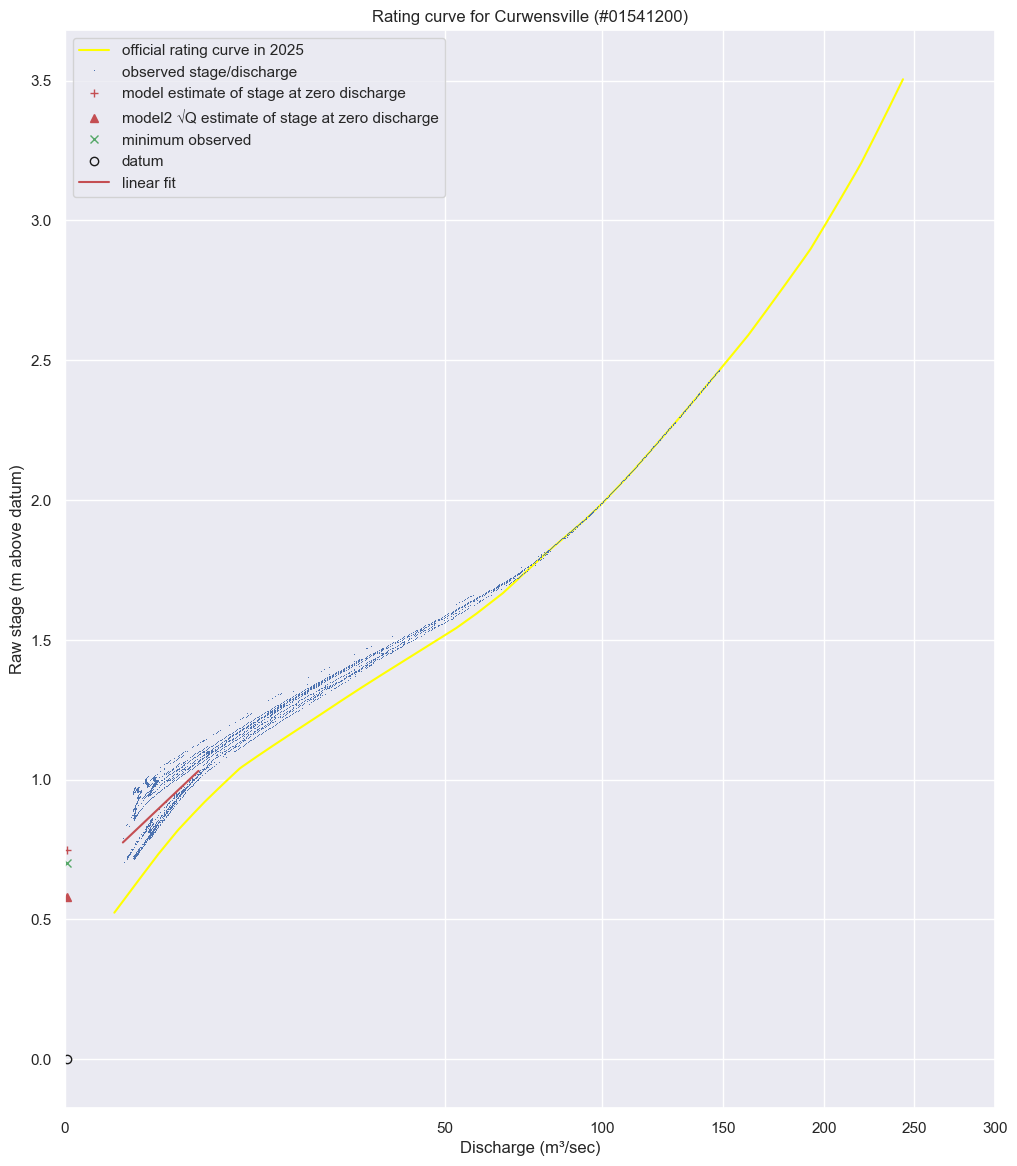

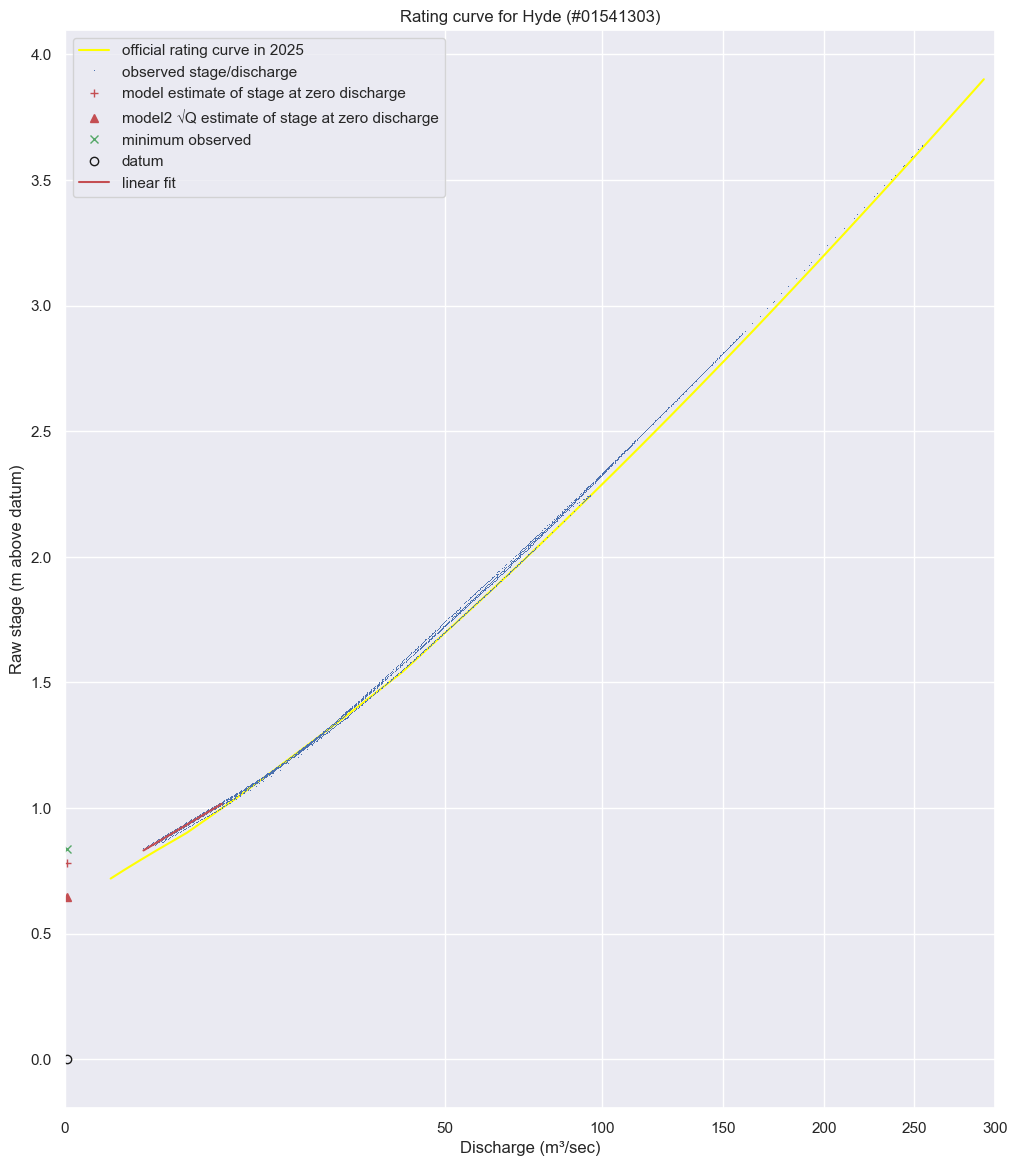

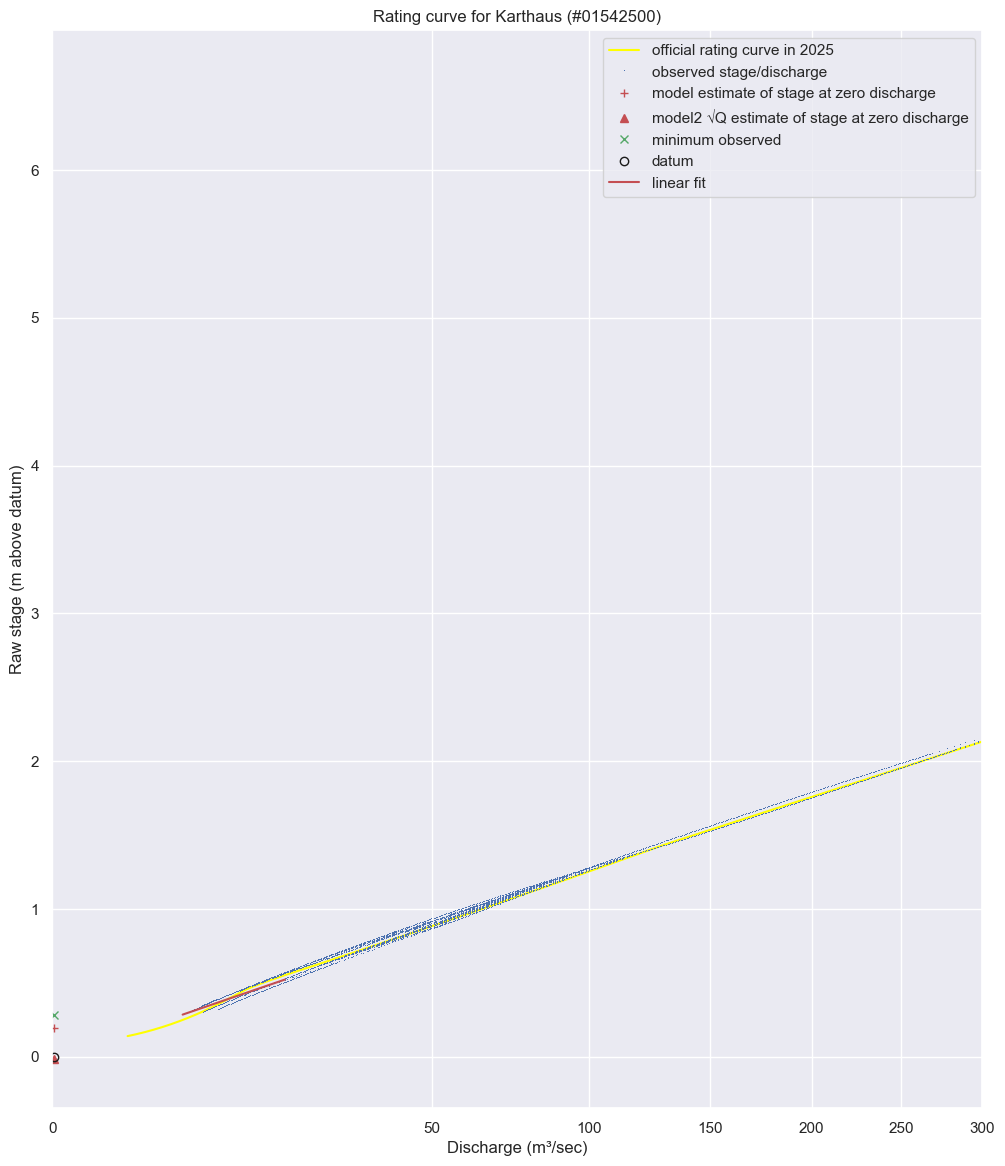

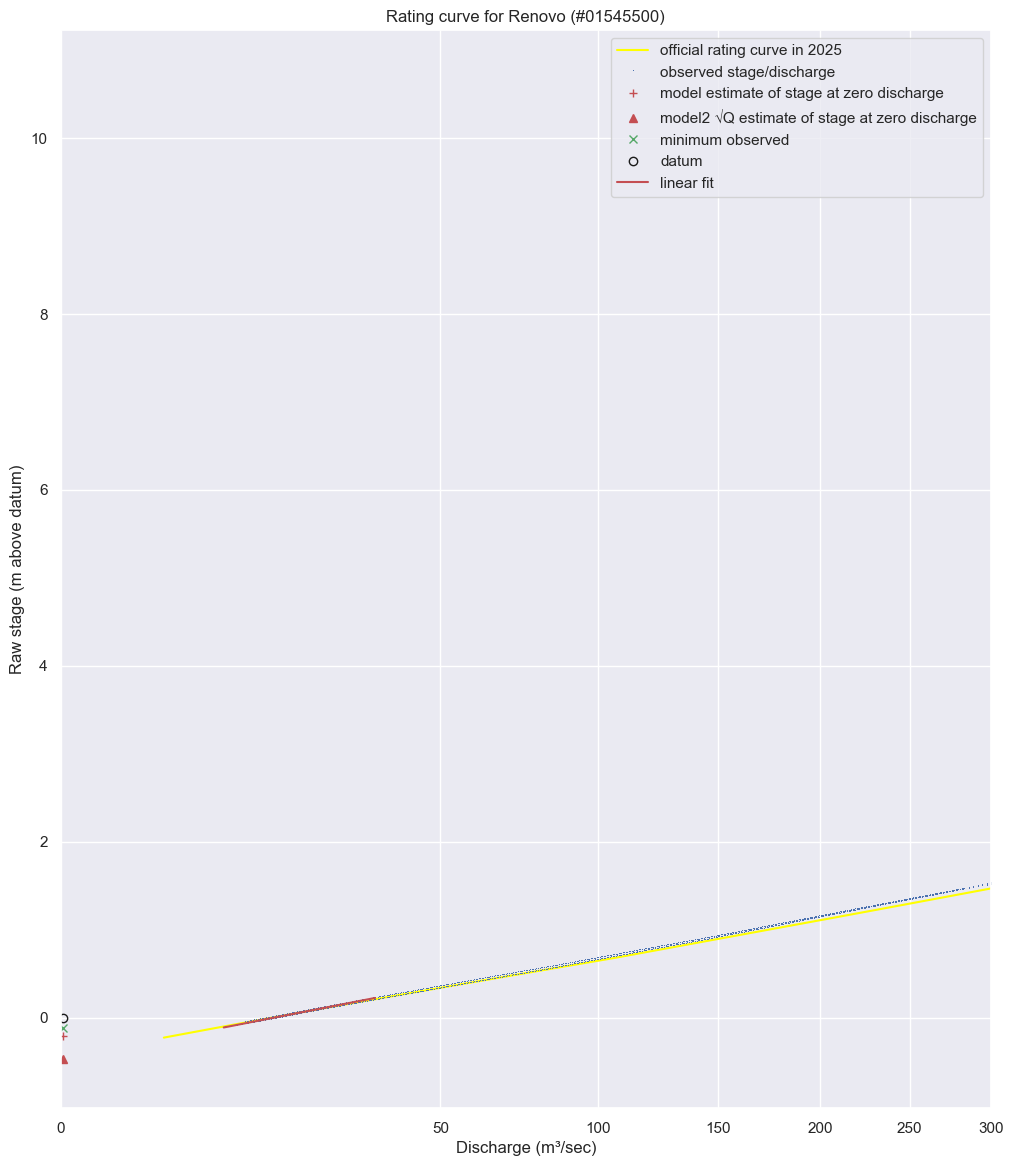

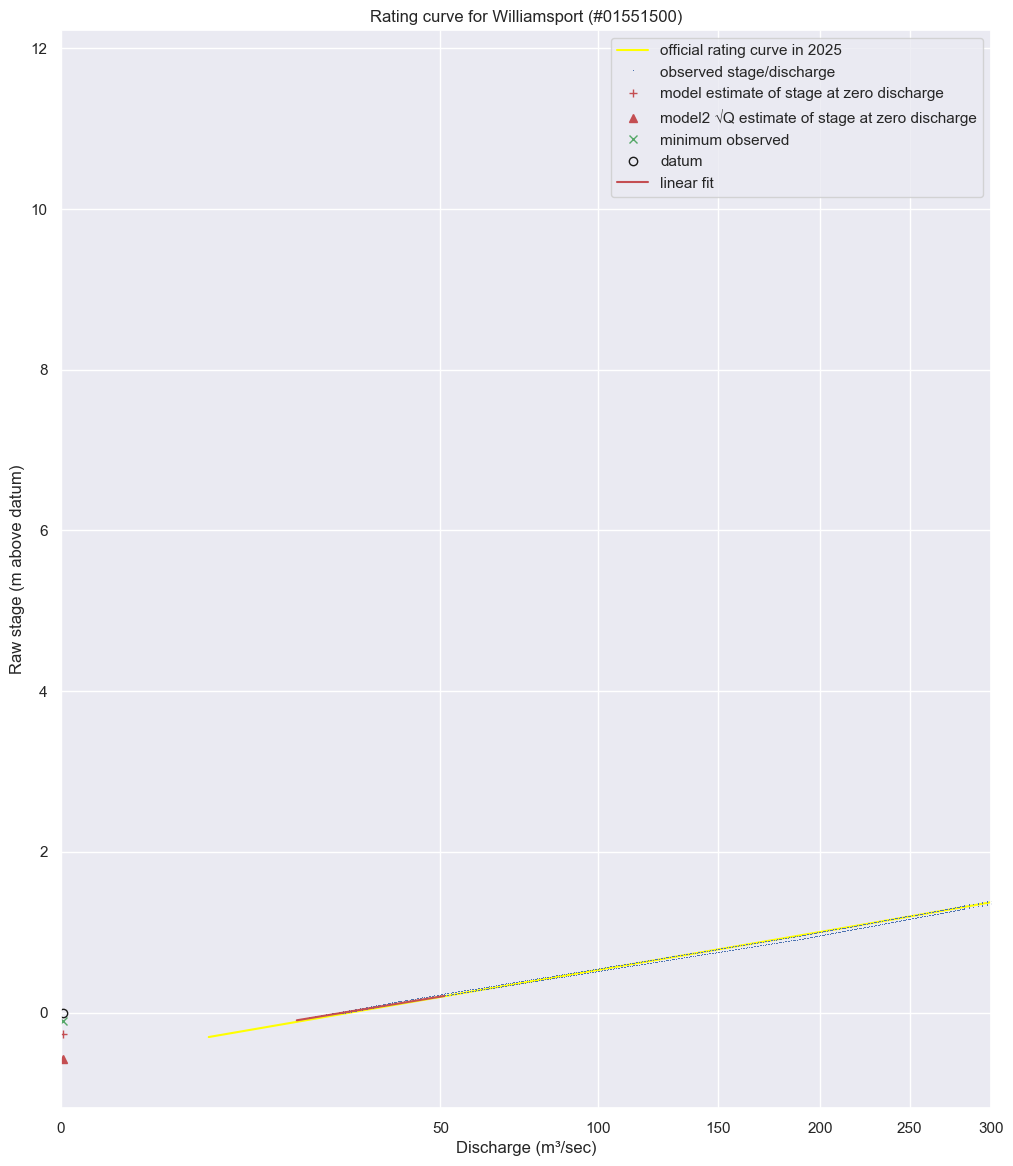

In [17]:
def forward(a):
    return np.sqrt(a)

def inverse(a):
    return a**2

for site in analysis_sites:
    sns.set_theme(style="darkgrid")
    fig, ax = plt.subplots(figsize=(12, 14))
    ax.plot(rating_curves[site].loc[:,'discharge_cms'], rating_curves[site].loc[:,'stage_m'], color='yellow', label='official rating curve in 2025')
    ax.plot(Q.loc[:,site], stage.loc[:,site], ',', label='observed stage/discharge')
    ax.plot(0.001, DF.loc[site,'StageQ0'], 'r+', label='model estimate of stage at zero discharge')
    ax.plot(0.001, DF.loc[site,'StageQ0root'], 'r^', label='model2 √Q estimate of stage at zero discharge')
    ax.plot(0.001, DF.loc[site, 'StageMin'], 'gx', label='minimum observed')
    ax.plot(0.001,0, 'ko', fillstyle='none', label='datum')
    # Set x values for the line to the highest & lowest values used in the fit
    xline = [DF.loc[site, 'minQ'], DF.loc[site, 'maxQ']]
    # The line was fit using √Q values, so must transform them before using these parameters
    yfunc = lambda x: DF.loc[site, 'gradient_root'] * x**0.5 + DF.loc[site, 'StageQ0root']
    yline = [yfunc(x) for x in xline]
    # All x values get transformed automatically during plotting
    ax.plot(xline, yline, 'r-', label='linear fit')
    ax.set_xscale('function', functions=(forward, inverse))
    ax.set_xlim([0, 300])
    ax.set_xlabel("Discharge (m³/sec)")
    ax.set_ylabel("Raw stage (m above datum)")
    ax.set_title("Rating curve for " + stations.loc[site, 'name'] + " (#" + site + ")" )
    ax.legend()

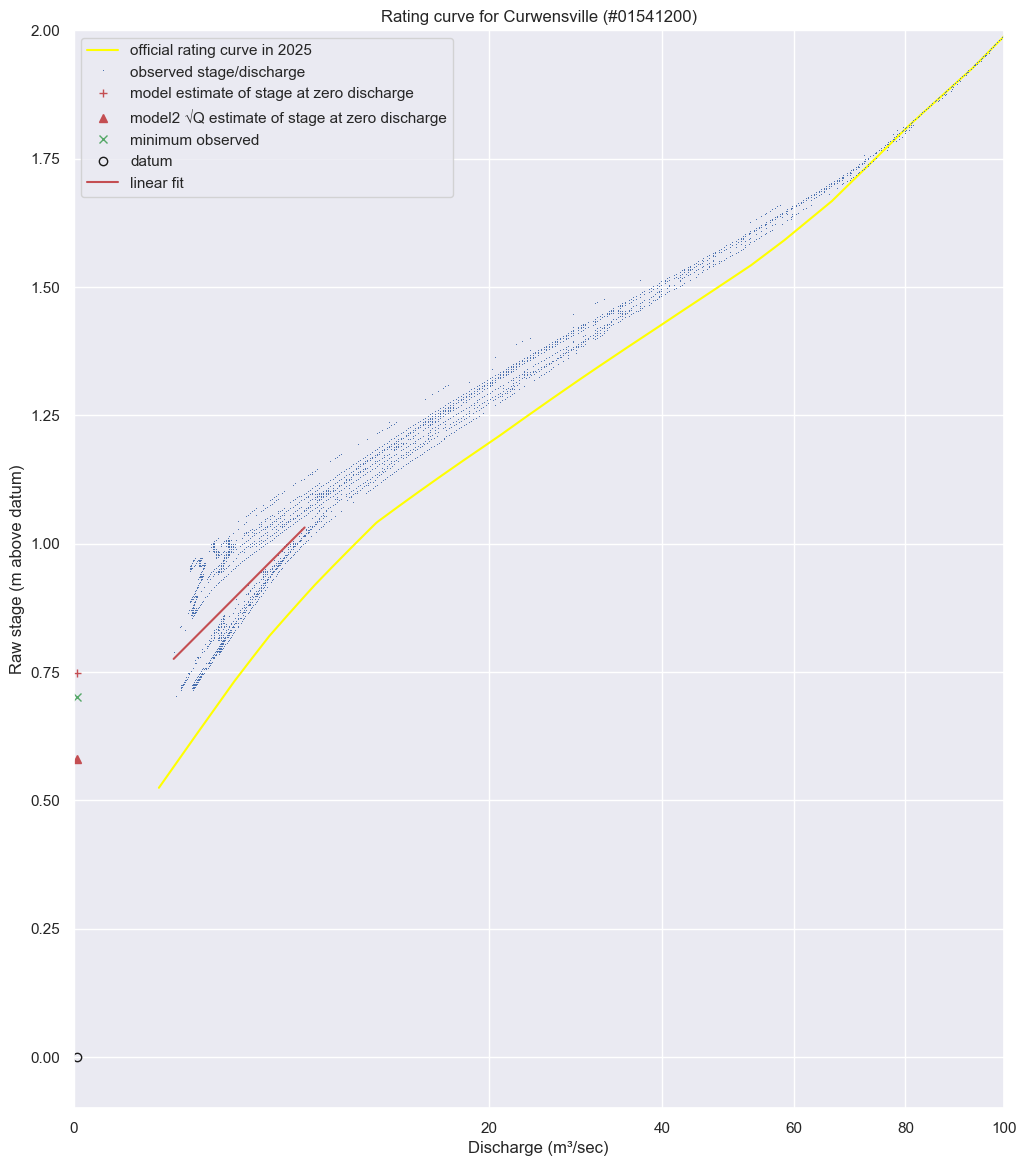

In [29]:
for site in ['01541200']:
    sns.set_theme(style="darkgrid")
    fig, ax = plt.subplots(figsize=(12, 14))
    ax.plot(rating_curves[site].loc[:,'discharge_cms'], rating_curves[site].loc[:,'stage_m'], color='yellow', label='official rating curve in 2025')
    ax.plot(Q.loc[:,site], stage.loc[:,site], ',', label='observed stage/discharge')
    ax.plot(0.001, DF.loc[site,'StageQ0'], 'r+', label='model estimate of stage at zero discharge')
    ax.plot(0.001, DF.loc[site,'StageQ0root'], 'r^', label='model2 √Q estimate of stage at zero discharge')
    ax.plot(0.001, DF.loc[site, 'StageMin'], 'gx', label='minimum observed')
    ax.plot(0.001,0, 'ko', fillstyle='none', label='datum')

    # Set x values for the line to the highest & lowest values used in the fit
    xline = [DF.loc[site, 'minQ'], DF.loc[site, 'maxQ']]
    # The line was fit using √Q values, so must transform them before using these parameters
    yfunc = lambda x: DF.loc[site, 'gradient_root'] * x**0.5 + DF.loc[site, 'StageQ0root']
    yline = [yfunc(x) for x in xline]
    # All x values get transformed automatically during plotting
    ax.plot(xline, yline, 'r-', label='linear fit')
    ax.set_xscale('function', functions=(forward, inverse))
    ax.set_xlim([0, 100])
    ax.set_ylim([-0.1, 2.0])
    ax.set_xlabel("Discharge (m³/sec)")
    ax.set_ylabel("Raw stage (m above datum)")
    ax.set_title("Rating curve for " + stations.loc[site, 'name'] + " (#" + site + ")" )
    ax.legend()

### Rating Curve notes:
There is no pattern to the order of the three 'stage-zero' estimates, but the datum is set much lower on the US stations than the DS stations. For most sites, the linear regression estimate is lower than the minimum discharge estimate.

This is not true for Curwensville. At this site, it appears that the rating curve has changed over time, so the minimum discharge has occured at stages ranging from 2.3 to 3.1 or so.

In this case, the Curwensville 'zero-stage' estimate should change over time, perhaps. The linear estimate perhaps represents the 'average' minimum stage, while the 'minimum' estimate represents the lowest stage estimate.

# Check median discharge
Compare the median discharge for the study period with USGS estimates

In [19]:
test_station = '01545500'

In [20]:
# This creates a table of discharge distributions for every day of the year
daily_stats = hf.stats(test_station, 'daily', parameterCd='00060')
daily_stats

Retrieved daily statistics for site #01545500 from https://waterservices.usgs.gov/nwis/stat//


,agency_cd,site_no,parameter_cd,ts_id,loc_web_ds,month_nu,day_nu,begin_yr,end_yr,count_nu,max_va_yr,max_va,min_va_yr,min_va,mean_va,p05_va,p10_va,p20_va,p25_va,p50_va,p75_va,p80_va,p90_va,p95_va
0,USGS,01545500,00060,323723,NaN,1,1,1962,2025,64,1993,35800,1999,700,6320,1040.0,1600,2200,2400,4720,7660,8450,11900,18800.0
1,USGS,01545500,00060,323723,NaN,1,2,1962,2024,63,1979,29600,1999,640,6580,1020.0,1600,2190,2530,4450,7390,9220,13800,25300.0
2,USGS,01545500,00060,323723,NaN,1,3,1962,2024,63,1979,31400,1999,600,6240,1060.0,1540,2180,2340,4380,8290,9020,13700,18000.0
3,USGS,01545500,00060,323723,NaN,1,4,1962,2024,63,1979,26100,1999,600,6150,984.0,1480,2180,2500,4270,7970,9320,14200,18600.0
4,USGS,01545500,00060,323723,NaN,1,5,1962,2024,63,2004,37600,1999,600,6260,1060.0,1500,2100,2300,4460,7800,8840,14800,19600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,USGS,01545500,00060,323723,NaN,12,27,1962,2025,64,1974,17500,1990,860,6000,1130.0,1660,2220,2700,5340,7920,9430,13200,15600.0
362,USGS,01545500,00060,323723,NaN,12,28,1962,2025,64,1974,26400,1990,900,5860,1130.0,1550,2100,2450,5220,7900,8650,11000,12500.0
363,USGS,01545500,00060,323723,NaN,12,29,1962,2025,64,1974,21500,1990,940,5880,1050.0,1530,2100,2280,5190,8360,8800,12200,14600.0
364,USGS,01545500,00060,323723,NaN,12,30,1962,2025,64,1985,19100,1990,940,5770,985.0,1500,2100,2420,5000,7380,8160,13300,14900.0


In [21]:
# This creates a table of mean daily discharge for each year
annual_stats = hf.stats(test_station, 'annual', parameterCd='00060', statYearType='water')
annual_stats

Retrieved annual statistics for site #01545500 from https://waterservices.usgs.gov/nwis/stat//


,agency_cd,site_no,parameter_cd,ts_id,loc_web_ds,year_nu,mean_va,count_nu
0,USGS,01545500,00060,323723,NaN,1962,3911,365
1,USGS,01545500,00060,323723,NaN,1963,3534,365
2,USGS,01545500,00060,323723,NaN,1964,4517,366
3,USGS,01545500,00060,323723,NaN,1965,3507,365
4,USGS,01545500,00060,323723,NaN,1966,3849,365
...,...,...,...,...,...,...,...,...
58,USGS,01545500,00060,323723,NaN,2020,4897,366
59,USGS,01545500,00060,323723,NaN,2021,4335,365
60,USGS,01545500,00060,323723,NaN,2022,5070,365
61,USGS,01545500,00060,323723,NaN,2023,3920,365


In [22]:
# List the median discharges that I calculated for the four year period
# Units: cubic meters per second
# median of all 15-minute measurements taken over four-year period at each station...
median

01541200      9.967514
01541303     14.186717
01542500     40.209856
01545500     84.667232
01551500    161.972096
Name: medianQ_cms, dtype: float64

In [23]:
60*60*24

86400

In [24]:
print(f"My median for {test_station}:  {median.loc[test_station]} cms")
print(f"Mean of daily median:    {daily_stats.table.loc[:,'p50_va'].mean()* 0.0283168} cms")
print(f"Median of daily median:  {daily_stats.table.loc[:,'p50_va'].median()* 0.0283168} cms")

My median for 01545500:  84.667232 cms
Mean of daily median:    98.05132999344262 cms
Median of daily median:  94.86128 cms


In [25]:
# It makes sense that this is higher... it comes from the annual mean values.
print(f"My median for {test_station}:   {median.loc[test_station]} cms")
print(f"Mean of annual mean:     {annual_stats.table.loc[:,'mean_va'].mean()* 0.0283168} cms")
print(f"Median of annual mean:   {annual_stats.table.loc[:,'mean_va'].median()* 0.0283168} cms")

My median for 01545500:   84.667232 cms
Mean of annual mean:     142.44429135238096 cms
Median of annual mean:   140.1115264 cms


In [26]:
site_file = hf.site_file(test_station)
site_file

Retrieved the site file for site #01545500 from https://waterservices.usgs.gov/nwis/site/?format=rdb&sites=01545500&siteOutput=expanded&siteStatus=alll


,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,coord_datum_cd,dec_coord_datum_cd,district_cd,state_cd,county_cd,country_cd,land_net_ds,map_nm,map_scale_fc,alt_va,alt_meth_cd,alt_acy_va,alt_datum_cd,huc_cd,basin_cd,topo_cd,instruments_cd,construction_dt,inventory_dt,drain_area_va,contrib_drain_area_va,tz_cd,local_time_fg,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no
0,USGS,01545500,"West Branch Susquehanna River at Renovo, PA",ST,411925,774501,41.323678,-77.749987,M,S,NAD27,NAD83,42,42,35,US,NaN,RENOVO WEST,24000,633.59,L,0.01,NAVD88,2050203,NaN,NaN,NNNNYNNNNNNNNNNNNNNNNNNNNNNNNN,NaN,NaN,2975,NaN,EST,Y,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# Compare watershed area
print(f"My area for {test_station}:  {stations.loc[test_station, 'basin_area_km2']} km²")
print(f"USGS site file area:   {site_file.table.loc[0, 'drain_area_va'] * 2.58998811} km²")

My area for 01545500:  7705.0 km²
USGS site file area:   7705.21462725 km²


In [28]:
# Compare datum height... this is the elevation of the zero point for stage measurements
print(f"My area for {test_station}:  {stations.loc[test_station, 'gauge_datum_m']} m ASL")
print(f"USGS site file area:   {site_file.table.loc[0, 'alt_va'] * 0.3048} m ASL")

My area for 01545500:  193.30111200000002 m ASL
USGS site file area:   193.118232 m ASL
